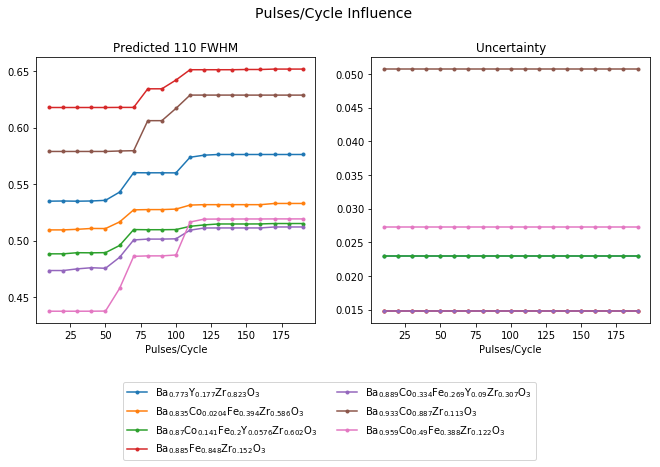

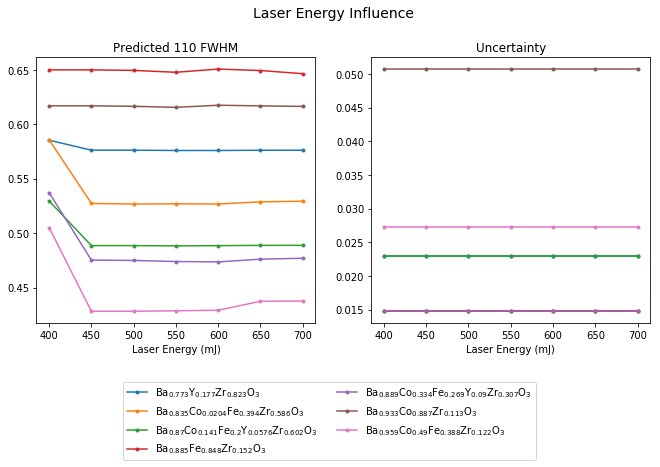

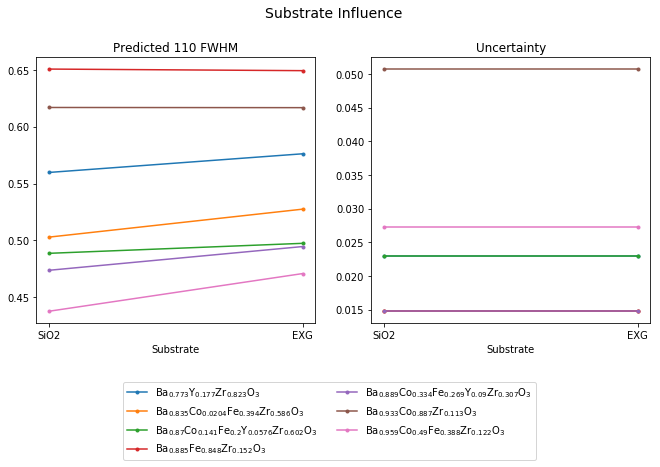

In [1]:
import os
from citrination_client import CitrinationClient
import pandas as pd
import pymatgen as mg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import ternary

client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')

#determine fwhm 110 dependence on processing parameters
view_id = '4198'

cand = pd.read_excel(os.path.join('input','predict_candidates_180424.xlsx'))

Asite = ['Ba']
Bsite = ['Co','Fe','Y','Zr']

for i in cand.index:
    comp = mg.Composition(cand.loc[i,'formula'])
    Asum = 0
    Bsum = 0
    for x in comp.elements:
        if str(x) in Asite: 
            Asum += comp.get_el_amt_dict()[str(x)]
        elif str(x) in Bsite:
            Bsum += comp.get_el_amt_dict()[str(x)]
    for x in comp.elements:
        if str(x) in Asite:
            wt = comp.get_el_amt_dict()[str(x)]/Asum #weight for wtd average
            cand.loc[i,'Property A_avg_X'] += wt*x.X
            cand.loc[i,'Property A_avg_at_radius'] += wt*x.atomic_radius
            cand.loc[i,'Property A_avg_ion_radius'] += wt*x.average_ionic_radius
            cand.loc[i,'Property A_avg_mass'] += wt*x.atomic_mass
            
        elif str(x) in Bsite:
            wt = comp.get_el_amt_dict()[str(x)]/Bsum #weight for wtd average
            cand.loc[i,'Property B_avg_X'] += wt*x.X
            cand.loc[i,'Property B_avg_at_radius'] += wt*x.atomic_radius
            cand.loc[i,'Property B_avg_ion_radius'] += wt*x.average_ionic_radius
            cand.loc[i,'Property B_avg_mass'] += wt*x.atomic_mass
            
    cand.loc[i,'Property AB_site_ratio'] = Asum/Bsum
    cand.loc[i,'Property AB_at_radius_ratio'] = cand.loc[i,'Property A_avg_at_radius']/cand.loc[i,'Property B_avg_at_radius']
    cand.loc[i,'Property AB_ion_radius_ratio'] = cand.loc[i,'Property A_avg_ion_radius']/cand.loc[i,'Property B_avg_ion_radius']
    cand.loc[i,'Property AB_mass_ratio'] = cand.loc[i,'Property A_avg_mass']/cand.loc[i,'Property B_avg_mass']
    
inputs = {}
tests = {'Average Target Pulses/Cycle (Step Pulsed Laser Deposition)':{'shortname':'Pulses/Cycle','suffix':'pulse_rate','units':''},
         'Laser Energy (Step Pulsed Laser Deposition)':{'shortname':'Laser Energy','suffix':'laser_energy','units':'mJ'},
         'Substrate (Step Pulsed Laser Deposition)':{'shortname':'Substrate','suffix':'substrate','units':''}}

for var, vdict in tests.items():
    df = cand[cand.test==var]
    inplist = []
    for i in df.index:
        inp = df.loc[i,'formula':].to_dict()
        for k,v in inp.items(): #need to convert numpy.int64 and numpy.float64 data types to non-numpy data types
            if type(v) != str:
                inp[k] = v.astype(str)
        inplist.append(inp)
    inputs[var] = inplist
    
    view_id = '4198'
    results = client.predict(view_id,inplist)
    candidates = results['candidates']
    
    formula = []
    fwhm = []
    err = []
    x = []

    for i in range(len(candidates)):
        formula.append(candidates[i]['formula'][0])
        fwhm.append(candidates[i]['Property FWHM of 110 peak'][0])
        err.append(candidates[i]['Property FWHM of 110 peak'][1])
        x.append(candidates[i][var][0])

    fig, axes = plt.subplots(1,2,figsize=(11,7))
    for f in np.unique(formula):
        fc = mg.Composition(f).get_el_amt_dict()
        fcstr = ''
        for k, v in fc.items():
            fcstr += k + '$_{{{0:.3g}}}$'.format(v)
        
        start = formula.index(f)
        end = len(formula) - formula[::-1].index(f)
        #plt.errorbar(x[start:end],fwhm[start:end],yerr=err[start:end], capsize = 4, marker='.',label=f)
        axes[0].plot(x[start:end],fwhm[start:end], marker='.',label=fcstr)
        
        axes[1].plot(x[start:end],err[start:end], marker='.',label=fcstr)
        
    testname = vdict['shortname']
    suffix = vdict['suffix']
    units = vdict['units']
    if len(units) > 0:
        xlab = '{} ({})'.format(testname,units)
    else:
        xlab = testname
    
    axes[0].set_xlabel(xlab)
    #axes[0].set_ylabel('Predicted 110 FWHM')
    axes[0].set_title('Predicted 110 FWHM')
    axes[1].set_xlabel(xlab)
    #axes[1].set_ylabel('110 FWHM Uncertainty')
    axes[1].set_title('Uncertainty')
    plt.suptitle(testname + ' Influence',fontsize=14)
    for ax in axes:
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height*0.3, box.width, box.height*0.7])
    
    plt.legend(loc='upper center',bbox_to_anchor=(-0.15,-0.2),ncol=2)
    #plt.savefig(os.path.join('plots','PredTest_' + suffix),dpi=350)
    

In [2]:
#optimize composition using formula as only input
view_id = '4209'
path = 'output'
design_file = 'design_formulas_180329.csv'
design_inp = pd.read_csv(os.path.join(path,design_file))
inputs = design_inp.to_dict('records')
candidates = []
for i in [0,1000,2000,3000]:
    cand = client.predict(view_id,inputs[i:i+1000])['candidates']
    candidates += cand

In [3]:
len(candidates)

3304

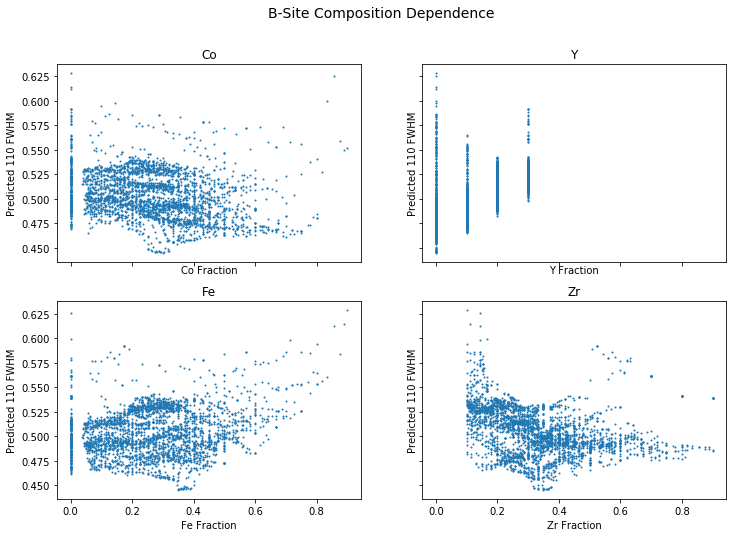

In [4]:
compresults = pd.DataFrame(columns=['formula','Co','Fe','Y','Zr','fwhm_110','error'])
for i, cand in enumerate(candidates):
    comp = mg.Composition(cand['formula'][0])
    compresults.loc[i,'formula'] = cand['formula'][0]
    compresults.loc[i,'fwhm_110':'error'] = cand['Property FWHM of 110 peak']
    for el in Bsite:
        compresults.loc[i,el] = comp.get_el_amt_dict()[el]
    

fig, axes = plt.subplots(2,2,figsize=(12,8),sharey=True,sharex=True)
for i, el in enumerate(Bsite):
    ax = axes[i%2,int(i/2)]
    ax.plot(compresults[el],compresults.fwhm_110,ls='',marker='.',markersize=2)
    ax.set_title(el)
    ax.set_xlabel(el + ' Fraction')
    ax.set_ylabel('Predicted 110 FWHM')
plt.suptitle('B-Site Composition Dependence',size=14)
plt.savefig(os.path.join('plots','BsiteComp_FWHM110.png'),dpi=350)

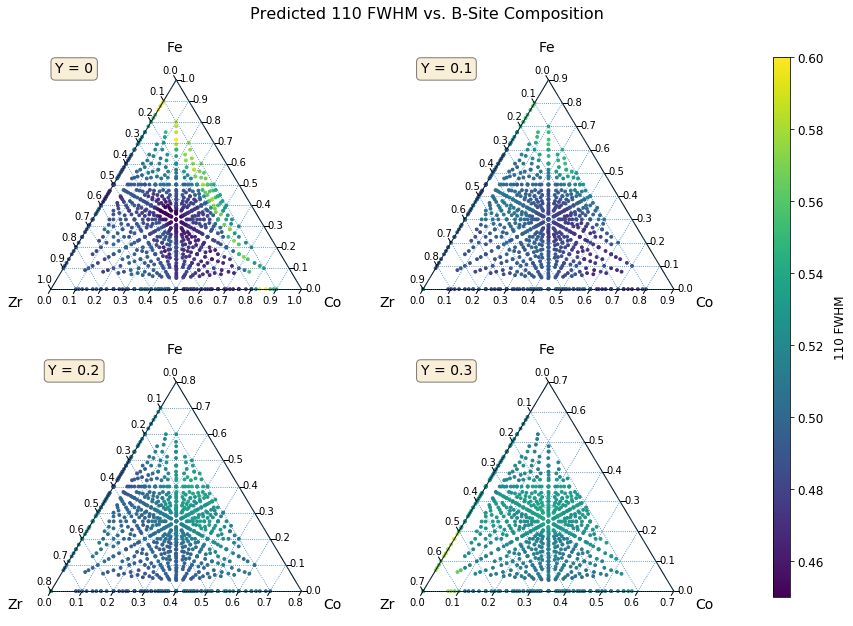

In [11]:
fig, axes = plt.subplots(2,2,figsize=(12,10))
Y_frac = [0,0.1,0.2,0.3]
full_colors = compresults.loc[:,'fwhm_110'].values
vmin=0.45
vmax=0.6


for i, nY in enumerate(Y_frac):
    df = compresults[compresults['Y']==nY]
    points = df.loc[:,['Co','Fe','Zr']].values
    colors = df.loc[:,'fwhm_110'].values
    
    ax=axes[int(i/2), i%2]
    
    scale = 1 - nY #point coords must sum to scale
    tfig, tax = ternary.figure(scale=scale,ax=ax)
    cmap = plt.cm.viridis
    tax.scatter(points,s=8,vmin=vmin,vmax=vmax,colormap=cmap,
                colorbar=False,c=colors)
    tax.boundary(linewidth=1.0)
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats='%.1f',offset=0.02)
    tax.gridlines(multiple=0.1,linewidth=0.8)
    tax.bottom_axis_label('Co',offset=0.1,fontsize=14, position=(1.05,0.03,0))
    tax.right_axis_label('Fe',offset=0.2,fontsize=14, position=(-0.13,1.25,0), rotation=0)
    tax.left_axis_label('Zr',offset=0.2,fontsize=14, position=(-0.10,0.03,1), rotation=0)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    tax.set_title('Y = {}'.format(nY),fontsize=14,x=0.13,y=0.97, bbox=props)
    tax._redraw_labels()
    ax.axis('off')
    
plt.suptitle('Predicted 110 FWHM vs. B-Site Composition',size=16,y=0.97)

#add a single colorbar
#make an axis for colorbar to control position/size
cbaxes = fig.add_axes([0.9,0.15,0.02,0.75]) #[left, bottom, width, height]
#code from colormapping.colorbar_hack
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = fig.colorbar(sm, ax=axes, cax = cbaxes)
cb.set_label('110 FWHM', fontsize=12, labelpad=10)
cb.ax.tick_params(labelsize=12)

fig.subplots_adjust(left=0.05,wspace=0.35, hspace=0.25, right=0.8)

plt.savefig(os.path.join('plots','Bsite_fwhm110_ternary_pred_180424.png'),dpi=350)

In [21]:
compresults[compresults.error>0.1]

,formula,Co,Fe,Y,Zr,fwhm_110,error
54,Ba0.85Co0.0Fe0.875Y0.0Zr0.125O3,0,0.875,0,0.125,0.610745,0.212459
63,Ba0.85Co0.0Fe0.889Y0.0Zr0.111O3,0,0.889,0,0.111,0.585525,0.212459
72,Ba0.85Co0.0Fe0.9Y0.0Zr0.1O3,0,0.9,0,0.1,0.587085,0.212459
2545,Ba0.85Co0.0Fe0.21Y0.3Zr0.49O3,0,0.21,0.3,0.49,0.595681,0.335089
2556,Ba0.85Co0.0Fe0.215Y0.3Zr0.485O3,0,0.215,0.3,0.485,0.594819,0.271015


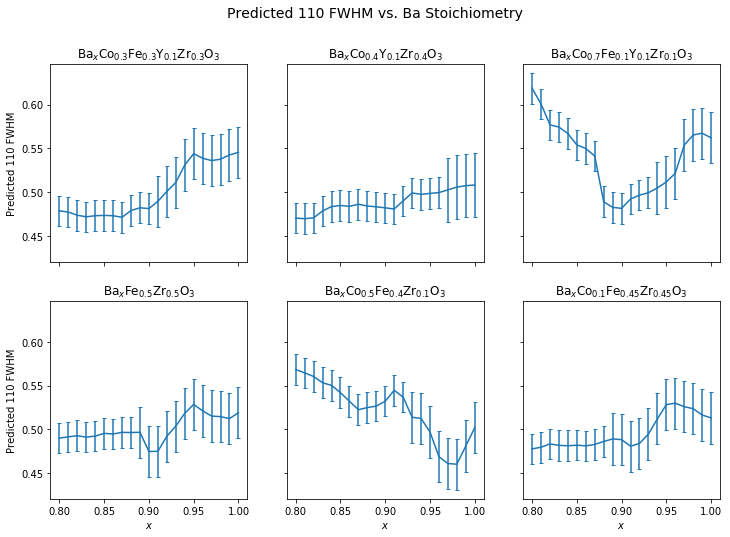

In [106]:
#test impact of Ba amount
Bcomps = ['Co0.3Fe0.3Y0.1Zr0.3', 'Fe0.5Zr0.5', 'Co0.4Y0.1Zr0.4','Co0.5Fe0.4Zr0.1', 'Co0.7Fe0.1Y0.1Zr0.1', 'Co0.1Fe0.45Zr0.45']

Ba_test = pd.DataFrame(columns=['formula','Bcomp','Ba','fwhm_110','error'])
for bc in Bcomps:
    nBa = np.arange(0.8,1.01,0.01)
    for n in nBa:
        frm = 'Ba' + str(n) + bc +'O3'
        Ba_test = Ba_test.append(pd.Series([frm,bc,n], index=['formula','Bcomp','Ba']), ignore_index=True)

inputs = Ba_test.formula.to_frame().to_dict('records')
view_id = '4209'
results = client.predict(view_id,inputs)['candidates']
for i, cand in enumerate(results):
    Ba_test.loc[i,'fwhm_110':'error'] = cand['Property FWHM of 110 peak']
    
fig, axes = plt.subplots(2,3,sharex=True, sharey=True,figsize=(12,8))
for i, bc in enumerate(Bcomps):
    ax = axes[i%2, int(i/2)]
    df = Ba_test[Ba_test['Bcomp']==bc]
    ax.errorbar(x=df['Ba'],y=df['fwhm_110'],yerr=df['error'],label=bc,capsize=2)
    
    bcd = mg.Composition(bc).get_el_amt_dict()
    bcstr = ''
    for k, v in bcd.items():
        bcstr += k + '$_{{{}}}$'.format(v)

    ax.set_title('Ba$_x$' + bcstr + 'O$_3$')
    if i%2 == 1:
        ax.set_xlabel('$x$')
    if int(i/2) == 0:
        ax.set_ylabel('Predicted 110 FWHM')
        
plt.suptitle('Predicted 110 FWHM vs. Ba Stoichiometry',size=14)
plt.savefig('plots/Asite_fwhm110_pred.png',dpi=350)

In [59]:
bcd = mg.Composition(bc).get_el_amt_dict()
bcstr = ''
for k, v in bcd.items():
    bcstr += k + '$_{{{}}}$'.format(v)
bcstr

'Co$_{0.5}$Fe$_{0.4}$Zr$_{0.1}$'

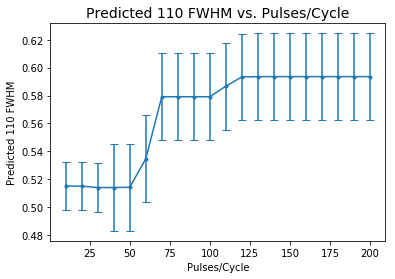

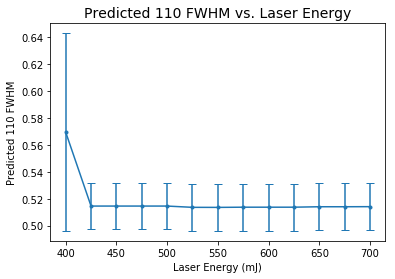

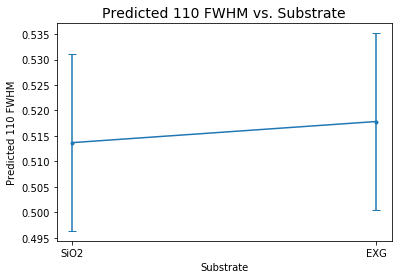

In [13]:
#optimize PLD params for chosen composition
view_id = '4198'

os.chdir(os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines\\Research\\MIDDMI\\TCO\\scripts'))
proc_cand = pd.read_excel(os.path.join('input','processing_predict_180330.xlsx'))

Asite = ['Ba']
Bsite = ['Co','Fe','Y','Zr']

for i in proc_cand.index:
    comp = mg.Composition(proc_cand.loc[i,'formula'])
    Asum = 0
    Bsum = 0
    for x in comp.elements:
        if str(x) in Asite: 
            Asum += comp.get_el_amt_dict()[str(x)]
        elif str(x) in Bsite:
            Bsum += comp.get_el_amt_dict()[str(x)]
    for x in comp.elements:
        if str(x) in Asite:
            wt = comp.get_el_amt_dict()[str(x)]/Asum #weight for wtd average
            proc_cand.loc[i,'Property A_avg_X'] += wt*x.X
            proc_cand.loc[i,'Property A_avg_at_radius'] += wt*x.atomic_radius
            proc_cand.loc[i,'Property A_avg_ion_radius'] += wt*x.average_ionic_radius
            proc_cand.loc[i,'Property A_avg_mass'] += wt*x.atomic_mass
            
        elif str(x) in Bsite:
            wt = comp.get_el_amt_dict()[str(x)]/Bsum #weight for wtd average
            proc_cand.loc[i,'Property B_avg_X'] += wt*x.X
            proc_cand.loc[i,'Property B_avg_at_radius'] += wt*x.atomic_radius
            proc_cand.loc[i,'Property B_avg_ion_radius'] += wt*x.average_ionic_radius
            proc_cand.loc[i,'Property B_avg_mass'] += wt*x.atomic_mass
            
    proc_cand.loc[i,'Property AB_site_ratio'] = Asum/Bsum
    proc_cand.loc[i,'Property AB_at_radius_ratio'] = proc_cand.loc[i,'Property A_avg_at_radius']/proc_cand.loc[i,'Property B_avg_at_radius']
    #proc_cand.loc[i,'Property AB_ion_radius_ratio'] = proc_cand.loc[i,'Property A_avg_ion_radius']/cand.loc[i,'Property B_avg_ion_radius']
    proc_cand.loc[i,'Property AB_mass_ratio'] = proc_cand.loc[i,'Property A_avg_mass']/proc_cand.loc[i,'Property B_avg_mass']
    
inputs = {}
tests = {'Average Target Pulses/Cycle (Step Pulsed Laser Deposition)':{'shortname':'Pulses/Cycle','suffix':'pulse_rate','units':''},
         'Laser Energy (Step Pulsed Laser Deposition)':{'shortname':'Laser Energy','suffix':'laser_energy','units':'mJ'},
         'Substrate (Step Pulsed Laser Deposition)':{'shortname':'Substrate','suffix':'substrate','units':''}}


for var, vdict in tests.items():
    df = proc_cand[proc_cand.test==var]
    inplist = []
    for i in df.index:
        inp = df.loc[i,'formula':].to_dict()
        for k,v in inp.items(): #need to convert numpy.int64 and numpy.float64 data types to non-numpy data types
            if type(v) != str:
                inp[k] = v.astype(str)
        inplist.append(inp)
    inputs[var] = inplist
    
    view_id = '4198'
    results = client.predict(view_id,inplist)
    candidates = results['candidates']
    
    formula = []
    fwhm = []
    err = []
    x = []

    for i in range(len(candidates)):
        formula.append(candidates[i]['formula'][0])
        fwhm.append(candidates[i]['Property FWHM of 110 peak'][0])
        err.append(candidates[i]['Property FWHM of 110 peak'][1])
        x.append(candidates[i][var][0])
    
    testname = vdict['shortname']
    suffix = vdict['suffix']
    units = vdict['units']
    if len(units) > 0:
        xlab = '{} ({})'.format(testname,units)
    else:
        xlab = testname
    
    plt.errorbar(x,fwhm,yerr=err,capsize=4,marker='.')
    
    plt.xlabel(xlab)
    plt.ylabel('Predicted 110 FWHM')
    plt.title('Predicted 110 FWHM vs. ' + testname,fontsize=14)
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0 + box.height*0.3, box.width, box.height*0.7])
    
    #plt.legend(loc='upper center',bbox_to_anchor=(-0.15,-0.2),ncol=2)
    #plt.savefig(os.path.join('plots','TestComp_' + suffix),dpi=350)
    plt.show()

In [14]:
inplist

[{'Average Target Pulses/Cycle (Step Pulsed Laser Deposition)': '25',
  'Deposition Pressure (Step Pulsed Laser Deposition)': '50',
  'Laser Energy (Step Pulsed Laser Deposition)': '600',
  'Laser Pulse Frequency (Step Pulsed Laser Deposition)': '10',
  'Number of Cycles (Step Pulsed Laser Deposition)': '200',
  'Property AB_X_ratio': '0',
  'Property AB_at_radius_ratio': '1.5140845070422533',
  'Property AB_mass_ratio': '2.117586309352009',
  'Property AB_site_ratio': '1.0000000000000002',
  'Property A_avg_X': '0.89',
  'Property A_avg_at_radius': '2.15',
  'Property A_avg_ion_radius': '1.49',
  'Property A_avg_mass': '137.327',
  'Property B_avg_X': '1.7540000000000002',
  'Property B_avg_at_radius': '1.4200000000000002',
  'Property B_avg_ion_radius': '0.8130833333333336',
  'Property B_avg_mass': '64.8507215',
  'Substrate (Step Pulsed Laser Deposition)': 'SiO2',
  'Temperature (Step Pulsed Laser Deposition)': '850',
  'Temperature Gradient (Step Pulsed Laser Deposition)': 'N',
  

In [51]:
#load new samples
datadir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines\\Research\\MIDDMI\\TCO\\Data')
proc = 'processed'
procdir = os.path.join(datadir,proc)
os.chdir(procdir)

varname = 'FWHM_110'
vardisp = 'PROPERTY: FWHM of 110 peak ($\degree$)'
procdat = pd.DataFrame()

prefix = 'PDAC_COM3_'
libs = ['01502','01505']

for ln in libs:
    lib = prefix + ln
    os.chdir(lib)
    pfname = '_'.join([lib,'AllVar.csv'])
        
    if os.path.exists(pfname):
        #read processed file
        pf = pd.read_csv(pfname)
        procdat = procdat.append(pf,ignore_index=True)
    
    os.chdir(procdir)

inputvar_4198 = {'FORMULA':'formula',
'PREPARATION STEP DETAIL: Average Target Pulses/Cycle':'Average Target Pulses/Cycle (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Temperature Gradient':'Temperature Gradient (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Temperature ($^{\circ}$C)':'Temperature (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Number of Cycles':'Number of Cycles (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Laser Pulse Frequency':'Laser Pulse Frequency (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Laser Energy (mJ)':'Laser Energy (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Laser Voltage (kV)':'Laser Voltage (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Substrate':'Substrate (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Deposition Pressure (mTorr)':'Deposition Pressure (Step Pulsed Laser Deposition)',
'PROPERTY: AB_mass_ratio':'Property AB_mass_ratio',
'PROPERTY: A_avg_ion_radius':'Property A_avg_ion_radius',
'PROPERTY: B_avg_ion_radius':'Property B_avg_ion_radius',
'PROPERTY: A_avg_at_radius':'Property A_avg_at_radius',
'PROPERTY: B_avg_at_radius':'Property B_avg_at_radius',
'PROPERTY: B_avg_X':'Property B_avg_X',
'PROPERTY: A_avg_X':'Property A_avg_X',
'PROPERTY: AB_at_radius_ratio':'Property AB_at_radius_ratio',
'PROPERTY: AB_ion_radius_ratio':'Property AB_ion_radius_ratio',
'PROPERTY: A_avg_mass':'Property A_avg_mass',
'PROPERTY: AB_X_ratio':'Property AB_X_ratio',
'PROPERTY: B_avg_mass':'Property B_avg_mass',
'PROPERTY: AB_site_ratio':'Property AB_site_ratio'}

inputvar_4431 = {'FORMULA':'formula',
'PREPARATION STEP DETAIL: Average Target Pulses/Cycle':'Average Target Pulses/Cycle (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Temperature Gradient':'Temperature Gradient (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Temperature ($^{\circ}$C)':'Temperature (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Number of Cycles':'Number of Cycles (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Laser Pulse Frequency':'Laser Pulse Frequency (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Laser Energy (mJ)':'Laser Energy (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Laser Voltage (kV)':'Laser Voltage (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Substrate':'Substrate (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Deposition Pressure (mTorr)':'Deposition Pressure (Step Pulsed Laser Deposition)',
'PROPERTY: AB_mass_ratio':'Property AB_mass_ratio',
'PROPERTY: A_avg_ion_radius':'Property A_avg_ion_radius',
'PROPERTY: B_avg_ion_radius':'Property B_avg_ion_radius',
'PROPERTY: A_avg_at_radius':'Property A_avg_at_radius',
'PROPERTY: B_avg_at_radius':'Property B_avg_at_radius',
'PROPERTY: B_avg_X':'Property B_avg_X',
'PROPERTY: A_avg_X':'Property A_avg_X',
'PROPERTY: AB_at_radius_ratio':'Property AB_at_radius_ratio',
'PROPERTY: AB_ion_radius_ratio':'Property AB_ion_radius_ratio',
'PROPERTY: A_avg_mass':'Property A_avg_mass',
'PROPERTY: AB_X_ratio':'Property AB_X_ratio',
'PROPERTY: B_avg_mass':'Property B_avg_mass',
'PROPERTY: AB_site_ratio':'Property AB_site_ratio',
'IDENTIFIER: Point':'Point',
'IDENTIFIER: Row':'Row',
'IDENTIFIER: Column':'Column',
'IDENTIFIER: X position (mm)':'X position',
'IDENTIFIER: Y position (mm)':'Y position'}

procdat = procdat.rename(columns=inputvar_4431)
procdat = procdat.rename(columns={'PROPERTY: FWHM of 110 peak ($\degree$)':'exp_fwhm'})

#predict using view 4198
# inp_4198 =  procdat[list(inputvar_4198.values())]
# inplist_4198 = inp_4198.to_dict('records')

# procpred_4198 = client.predict('4198',inplist_4198)['candidates']

# for i, pdict in enumerate(procpred_4198):
#     try:
#         formula = pdict['formula'][0]
#         fwhm = pdict['Property FWHM of 110 peak'][0]
#         unc = pdict['Property FWHM of 110 peak'][1]
#         idx = procdat[procdat['formula']==formula].index
#         procdat.loc[idx, 'pred_fwhm_4198'] = fwhm
#         procdat.loc[idx, 'pred_unc_4198'] = unc
#     except KeyError: #some formulas have negative units for some elements - can't predict
#         print('Bad formula for index {}'.format(i))

# procdat['pred_err_4198'] = procdat['pred_fwhm_4198'] - procdat['exp_fwhm']   

#predict using view 4431 - incldues position identifiers
inp_4431 =  procdat[list(inputvar_4431.values())]
inplist_4431 = inp_4431.to_dict('records')
procpred_4431 = client.predict('4431',inplist_4431)['candidates']

for i, pdict in enumerate(procpred_4431):
    try:
        formula = pdict['formula'][0]
        fwhm = pdict['Property FWHM of 110 peak'][0]
        unc = pdict['Property FWHM of 110 peak'][1]
        idx = procdat[procdat['formula']==formula].index
        procdat.loc[idx, 'pred_fwhm_4431'] = fwhm
        procdat.loc[idx, 'pred_unc_4431'] = unc
    except KeyError: #some formulas have negative units for some elements - can't predict
        print('Bad formula for index {}'.format(i))

procdat['pred_err_4431'] = procdat['pred_fwhm_4431'] - procdat['exp_fwhm']   

In [50]:
#client.predict(4431,inplist_4431[0])
inplist_4431[1]

{'Average Target Pulses/Cycle (Step Pulsed Laser Deposition)': 19.33333333333333,
 'Column': 2,
 'Deposition Pressure (Step Pulsed Laser Deposition)': 50.0,
 'Laser Energy (Step Pulsed Laser Deposition)': 550.0,
 'Laser Pulse Frequency (Step Pulsed Laser Deposition)': 20,
 'Laser Voltage (Step Pulsed Laser Deposition)': 19.3,
 'Number of Cycles (Step Pulsed Laser Deposition)': 1000.0,
 'Point': 2,
 'Property AB_X_ratio': 0.5223004250550443,
 'Property AB_at_radius_ratio': 1.5049977367106089,
 'Property AB_ion_radius_ratio': 1.839014527572281,
 'Property AB_mass_ratio': 2.003706110135894,
 'Property AB_site_ratio': 0.8481139045825076,
 'Property A_avg_X': 0.8899959025805226,
 'Property A_avg_at_radius': 2.1499901017394647,
 'Property A_avg_ion_radius': 1.4899931402752569,
 'Property A_avg_mass': 137.32636776817463,
 'Property B_avg_X': 1.7039923,
 'Property B_avg_at_radius': 1.428567,
 'Property B_avg_ion_radius': 0.8102128166666667,
 'Property B_avg_mass': 68.53618256365,
 'Row': 1,
 '

In [47]:
procdat.columns

Index(['formula', 'IDENTIFIER: Sample number', 'Point', 'Row', 'Column',
       'PROPERTY: Cubic lattice constant ($\r{A}$)',
       'PROPERTY: Film thickness ($\mu$m)', 'exp_fwhm',
       'PROPERTY: FWHM of 111 peak ($\degree$)',
       'PROPERTY: FWHM of 200 peak ($\degree$)',
       'PROPERTY: Max intensity of 110 peak (counts)',
       'PROPERTY: Max intensity of 111 peak (counts)',
       'PROPERTY: Max intensity of 200 peak (counts)',
       'PROPERTY: Position of 110 peak ($\degree$)',
       'PROPERTY: Position of 111 peak ($\degree$)',
       'PROPERTY: Position of 200 peak ($\degree$)', 'X position',
       'Y position', 'Property A_avg_X', 'Property A_avg_at_radius',
       'Property A_avg_ion_radius', 'Property A_avg_mass', 'Property B_avg_X',
       'Property B_avg_at_radius', 'Property B_avg_ion_radius',
       'Property B_avg_mass', 'Property AB_site_ratio', 'Property AB_X_ratio',
       'Property AB_at_radius_ratio', 'Property AB_ion_radius_ratio',
       'Property AB_m

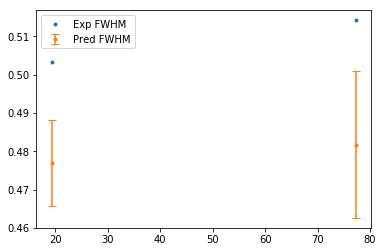

In [8]:
pdavg = procdat.groupby('IDENTIFIER: Sample number').mean()

# for sn in pdavg.index:
#     df = pdavg.loc[sn,:]
plt.plot(pdavg['Average Target Pulses/Cycle (Step Pulsed Laser Deposition)'],
     pdavg['exp_fwhm'],
    ls='', marker='.', label = 'Exp FWHM')

plt.errorbar(pdavg['Average Target Pulses/Cycle (Step Pulsed Laser Deposition)'],
     pdavg['pred_fwhm'],
    yerr=pdavg['pred_unc'], capsize=4,
    ls='', marker='.', label = 'Pred FWHM')

plt.legend()

# plt.plot(procdat['Average Target Pulses/Cycle (Step Pulsed Laser Deposition)'],
#          procdat['PROPERTY: FWHM of 110 peak ($\degree$)'],
#         ls='', marker='.')


In [43]:
procdat.columns

Index(['formula', 'IDENTIFIER: Sample number', 'Point', 'Row', 'Column',
       'PROPERTY: Cubic lattice constant ($\r{A}$)',
       'PROPERTY: Film thickness ($\mu$m)', 'exp_fwhm',
       'PROPERTY: FWHM of 111 peak ($\degree$)',
       'PROPERTY: FWHM of 200 peak ($\degree$)',
       'PROPERTY: Max intensity of 110 peak (counts)',
       'PROPERTY: Max intensity of 111 peak (counts)',
       'PROPERTY: Max intensity of 200 peak (counts)',
       'PROPERTY: Position of 110 peak ($\degree$)',
       'PROPERTY: Position of 111 peak ($\degree$)',
       'PROPERTY: Position of 200 peak ($\degree$)',
       'IDENTIFIER: X position (mm)', 'IDENTIFIER: Y position (mm)',
       'Property A_avg_X', 'Property A_avg_at_radius',
       'Property A_avg_ion_radius', 'Property A_avg_mass', 'Property B_avg_X',
       'Property B_avg_at_radius', 'Property B_avg_ion_radius',
       'Property B_avg_mass', 'Property AB_site_ratio', 'Property AB_X_ratio',
       'Property AB_at_radius_ratio', 'Property AB

-0.026444094857913138
-0.032409999219260646


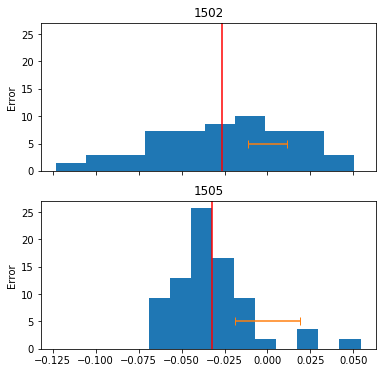

In [17]:
fig, axes = plt.subplots(2,1,sharex=True, sharey=True, figsize=(6,6))
for i, sn in enumerate(procdat['IDENTIFIER: Sample number'].unique()):
    ax = axes[i]
    df = procdat[procdat['IDENTIFIER: Sample number']==sn]
    df = df.drop(axis=0,index=df[pd.isnull(df['pred_err'])].index) #remove nans
    ax.hist(df['pred_err'],density=True)
    ax.set_title(sn)
    #plt.xlim([-0.125,0.125])
    avg = df['pred_err'].mean()
    ax.axvline(avg, color='red')
    err = df['pred_unc'].mean()
    ax.errorbar(x=0,y=5,xerr=err,capsize=4)
    print(avg)
    ax.set_ylabel('Error')

0.5032376075
0.5141810627272728


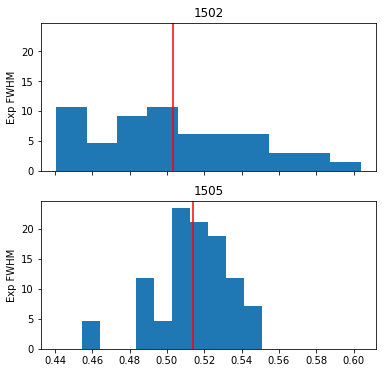

In [18]:
fig, axes = plt.subplots(2,1,sharex=True, sharey=True, figsize=(6,6))
for i, sn in enumerate(procdat['IDENTIFIER: Sample number'].unique()):
    ax = axes[i]
    df = procdat[procdat['IDENTIFIER: Sample number']==sn]
    df = df.drop(axis=0,index=df[pd.isnull(df['exp_fwhm'])].index) #remove nans
    ax.hist(df['exp_fwhm'],density=True)
    ax.set_title(sn)
    #plt.xlim([-0.125,0.125])
    avg = df['exp_fwhm'].mean()
    ax.axvline(avg, color='red')
    print(avg)
    ax.set_ylabel('Exp FWHM')

Text(0.5,1,'Average Error')

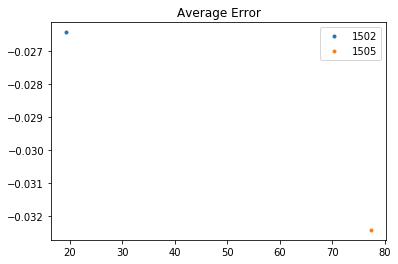

In [19]:
for sn in pdavg.index:
    df = pdavg.loc[sn,:]
    plt.plot(df['Average Target Pulses/Cycle (Step Pulsed Laser Deposition)'],
         df['pred_err'],
        ls='', marker='.', label = sn)
plt.legend()
plt.title('Average Error')

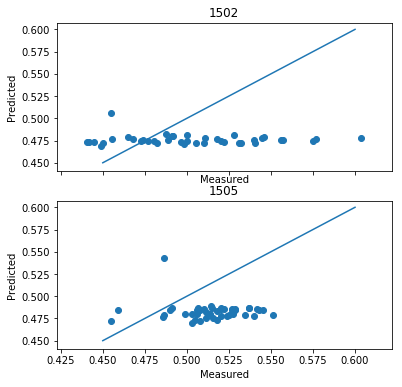

In [53]:
fig, axes = plt.subplots(2,1,sharex=True, sharey=True, figsize=(6,6))
for i, sn in enumerate(procdat['IDENTIFIER: Sample number'].unique()):
    ax = axes[i]
    df = procdat[procdat['IDENTIFIER: Sample number']==sn]
    df = df.drop(axis=0,index=df[pd.isnull(df['exp_fwhm'])].index) #remove nans
    ax.scatter(df['exp_fwhm'],df['pred_fwhm_4431'])
    ax.set_title(sn)
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Measured')
    lin = [0.45,0.6]
    ax.plot(lin,lin)

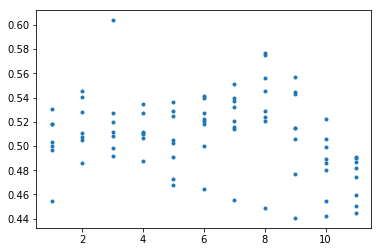

In [25]:
plt.plot(procdat['IDENTIFIER: Column'],procdat['exp_fwhm'], ls = '', marker='.')

<Container object of 3 artists>

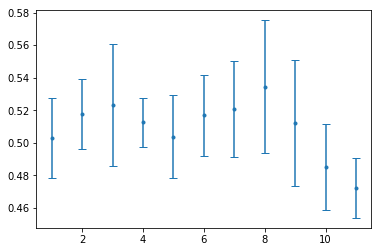

In [38]:
colavg = procdat.groupby('IDENTIFIER: Column').mean()
colstd = procdat.groupby('IDENTIFIER: Column').std()
plt.errorbar(colavg.index,colavg['exp_fwhm'], ls = '', marker='.',yerr=colstd['exp_fwhm'],capsize=4)

In [36]:
colstd

,IDENTIFIER: Sample number,IDENTIFIER: Point,IDENTIFIER: Row,PROPERTY: Cubic lattice constant ($\r{A}$),PROPERTY: Film thickness ($\mu$m),exp_fwhm,PROPERTY: FWHM of 111 peak ($\degree$),PROPERTY: FWHM of 200 peak ($\degree$),PROPERTY: Max intensity of 110 peak (counts),PROPERTY: Max intensity of 111 peak (counts),...,PREPARATION STEP DETAIL: BZC19 Substrate Angle,PREPARATION STEP DETAIL: BZC91 Substrate Angle,PREPARATION STEP DETAIL: BZF19 Substrate Angle,PREPARATION STEP DETAIL: BZY82 Substrate Angle,PREPARATION STEP DETAIL: BZYCF1135 Substrate Angle,PREPARATION STEP DETAIL: BZYF631 Substrate Angle,PREPARATION STEP DETAIL: B12ZY82 Substrate Angle,pred_fwhm,pred_unc,pred_err
IDENTIFIER: Column,,,,,,,,,,,,,,,,,,,,,
1,1.603567,13.147515,1.195229,0.010824,0.045542,0.024528,0.049854,0.114290,2931.903575,949.382093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002672,0.004236,0.024381
2,1.603567,13.147515,1.195229,0.011417,0.051174,0.021468,0.036770,0.068337,3129.272997,761.825822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001372,0.004236,0.022296
3,1.603567,13.147515,1.195229,0.011828,0.055832,0.037570,0.042246,0.086540,3007.180512,1084.549376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004766,0.004236,0.036482
4,1.603567,13.147515,1.195229,0.011908,0.061697,0.014968,0.023501,0.031916,2779.363222,1280.662650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003953,0.004236,0.015861
5,1.603567,13.147515,1.195229,0.011907,0.066221,0.025429,0.046337,0.068338,2825.471375,1583.858241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004462,0.004236,0.022625
6,1.603567,13.147515,1.195229,0.012827,0.070615,0.024658,0.056023,0.151073,2291.041877,1441.777792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003176,0.004236,0.023866
7,1.603567,13.147515,1.195229,0.012241,0.073228,0.029340,0.020205,0.166029,1950.341745,1012.879275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003444,0.004236,0.029862
8,1.603567,13.147515,1.195229,0.011093,0.072999,0.040903,0.012348,0.030783,1878.347365,828.528858,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002882,0.004236,0.040863
9,1.603567,13.147515,1.195229,0.008638,0.072259,0.038642,0.017797,0.105018,1734.215060,846.302970,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004118,0.004236,0.037756


<Container object of 3 artists>

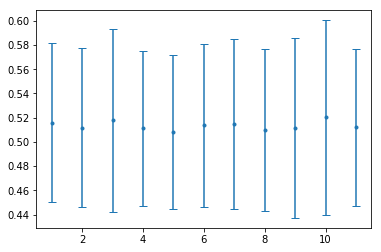

In [39]:
#load all samples to check impact of point/row/column
datadir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines\\Research\\MIDDMI\\TCO\\Data')
proc = 'processed'
procdir = os.path.join(datadir,proc)
os.chdir(procdir)

fulldat = pd.DataFrame()


for lib in next(os.walk(procdir))[1]:
    os.chdir(lib)
    pfname = '_'.join([lib,'AllVar.csv'])
        
    if os.path.exists(pfname):
        #read processed file
        pf = pd.read_csv(pfname)
        fulldat = fulldat.append(pf,ignore_index=True)
    
    os.chdir(procdir)

inputvar = {'FORMULA':'formula',
'PREPARATION STEP DETAIL: Average Target Pulses/Cycle':'Average Target Pulses/Cycle (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Temperature Gradient':'Temperature Gradient (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Temperature ($^{\circ}$C)':'Temperature (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Number of Cycles':'Number of Cycles (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Laser Pulse Frequency':'Laser Pulse Frequency (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Laser Energy (mJ)':'Laser Energy (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Substrate':'Substrate (Step Pulsed Laser Deposition)',
'PREPARATION STEP DETAIL: Deposition Pressure (mTorr)':'Deposition Pressure (Step Pulsed Laser Deposition)',
'PROPERTY: AB_mass_ratio':'Property AB_mass_ratio',
'PROPERTY: A_avg_ion_radius':'Property A_avg_ion_radius',
'PROPERTY: B_avg_ion_radius':'Property B_avg_ion_radius',
'PROPERTY: A_avg_at_radius':'Property A_avg_at_radius',
'PROPERTY: B_avg_at_radius':'Property B_avg_at_radius',
'PROPERTY: B_avg_X':'Property B_avg_X',
'PROPERTY: A_avg_X':'Property A_avg_X',
'PROPERTY: AB_at_radius_ratio':'Property AB_at_radius_ratio',
'PROPERTY: A_avg_mass':'Property A_avg_mass',
'PROPERTY: AB_X_ratio':'Property AB_X_ratio',
'PROPERTY: B_avg_mass':'Property B_avg_mass',
'PROPERTY: AB_site_ratio':'Property AB_site_ratio'}

fulldat = fulldat.rename(columns=inputvar)
fulldat = fulldat.rename(columns={'PROPERTY: FWHM of 110 peak ($\degree$)':'exp_fwhm'})


colavgfull = fulldat.groupby('IDENTIFIER: Column').mean()
colstdfull = fulldat.groupby('IDENTIFIER: Column').std()
plt.errorbar(colavgfull.index,colavgfull['exp_fwhm'], ls = '', marker='.',yerr=colstdfull['exp_fwhm'],capsize=4)